In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PyTorch関係
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

ニューラルネットワーク「PyTorch」の、深層距離学習を行うためのライブラリの1つである
「Pytorch Metric Learning」を利用します。

学習後に各ベクトルがどのクラスに一番近いかを調べて評価できるようにするために
faiss-gpuは「FAISS」(Facebook AI Similarity Search)という近似最近傍探索アルゴリズムのためのライブラリです。
ここで、PyTorch Metric Learning の AccuracyCalculatorクラスを使うためにインストールします。


In [3]:
# 深層距離学習用
from pytorch_metric_learning import distances, losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

学習後のベクトル同士の距離関係を2次元で可視化するためのアルゴリズム「t-SNE」を使えるようにする
Pythonの機会学習ライブラリである「scikit-learn」にはt-SNEを実行するためのクラスがありますが、データサイズが大きいと処理が非常に遅くなります。そこでその代わりに「t-SNE-CUDA」というライブラリを入れます。GPUも使うことで、高速にt-SNEを実行できるようになります。

In [4]:
# 可視化用
#from sklearn.manifold import TSNE # 遅い
from tsnecuda import TSNE # 高速

In [5]:
# 用いるデバイスを変数へ
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cuda:0


# 「MNIST」と呼ばれる、0から9の手書き数字のデータセットを使って深層距離学習を行ってみましょう

まず、データを読み込みます。学習用に6万枚、テスト用に1万枚の画像が、それぞれdataset1およびdataset2としてダウンロードされます。

In [6]:
# データセットの準備
transform = transforms.Compose(
  [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# データセットの用意（初回はダウンロードされる）
dataset1 = datasets.MNIST('.', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('.', train=False, transform=transform)


学習時にバッチ単位（ここでは256枚ずつ）でデータを読み込むことで
ニューラルネットをミニバッチで学習できるように、`DataLoader`クラスのインスタンス（`train_loader`）を用意します。

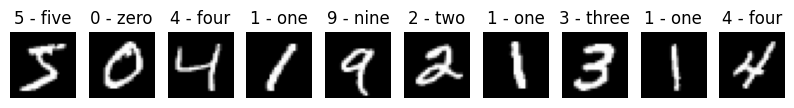

In [7]:
batch_size = 256 # バッチサイズ

# PyTorchの DataLoaderへ
train_loader = torch.utils.data.DataLoader(
  dataset1, batch_size=batch_size, shuffle=True
)

# 学習用画像を10枚表示してみる
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
  ax[i].imshow(np.array(dataset1[i][0].permute(1,2,0)), cmap='gray')
  ax[i].set_title(dataset1.classes[dataset1[i][1]])
  ax[i].axis('off')
plt.show()

## 深層距離学習の実行

画像エンコーダーは*E*という関数で表現します。画像エンコーダー*E*による画像のベクトル空間への埋め込みは
$z=E(I)$ と表現され、画像*I*が入力されると、特徴ベクトル*z*へと変換します。

画像エンコーダー*E*は、ここでは2つの畳み込み層と1つの全結合層を持つ、単純な畳み込みニューラルネット（CNN）を用いることにする

forward() が実際に入力画像に対して行われる処理（順伝播）で、784ピクセル（＝縦28ピクセル×横28ピクセル）の画像データの入力を、
畳み込み層で画像特徴を抽出しつつ、全結合層`fc1`通過後は128次元の画像特徴ベクトル*z*に変換します。

In [1]:
# 2層の畳み込み層を持つ単純なCNN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 128)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

NameError: name 'nn' is not defined

flowchart LR
    %% 入力層
    subgraph 入力
      direction TB
      N0[ノイズ=1]
      X1[x₁]
      X2[x₂]
    end

    %% 第1隠れ層
    subgraph 隠れ層1
      direction TB
      Z11[z₁₁]
      Z12[z₁₂]
      Z13[z₁₃]
      Z14[z₁₄]
    end

    %% 第2隠れ層
    subgraph 隠れ層2
      direction TB
      N1[ノイズ=1]
      Z21[z₂₁]
      Z22[z₂₂]
      Z23[z₂₃]
      Z24[z₂₄]
    end

    %% 出力層
    subgraph 出力
      direction TB
      N2[ノイズ=1]
      Y1[y₁]
      Y2[y₂]
    end

    %% 入力→第1隠れ層
    N0 --> Z11
    N0 --> Z12
    N0 --> Z13
    N0 --> Z14

    X1 --> Z11
    X1 --> Z12
    X1 --> Z13
    X1 --> Z14

    X2 --> Z11
    X2 --> Z12
    X2 --> Z13
    X2 --> Z14

    %% 第1隠れ層→第2隠れ層
    Z11 --> Z21
    Z11 --> Z22
    Z11 --> Z23
    Z11 --> Z24

    Z12 --> Z21
    Z12 --> Z22
    Z12 --> Z23
    Z12 --> Z24

    Z13 --> Z21
    Z13 --> Z22
    Z13 --> Z23
    Z13 --> Z24

    Z14 --> Z21
    Z14 --> Z22
    Z14 --> Z23
    Z14 --> Z24

    N1 --> Z21
    N1 --> Z22
    N1 --> Z23
    N1 --> Z24

    %% 第2隠れ層→出力層
    Z21 --> Y1
    Z21 --> Y2

    Z22 --> Y1
    Z22 --> Y2

    Z23 --> Y1
    Z23 --> Y2

    Z24 --> Y1
    Z24 --> Y2

    N2 --> Y1
    N2 --> Y2


## 損失関数とは
「現時点のニューラルネットの出力」と、「理想的な出力」との「ずれ」を、何らかの方法で測る関数です。
学習時には、損失関数の出力（値）が小さくなっていくようにニューラルネットのパラメータを更新していきます。
ここでは「対象損失」と呼ばれる損失関数を使います。具体的な関数には様々なものがありますが、ここで紹介する対象損失は、正解ラベルが与えられる「教師あり学習」で用いられる場合と、正解を疑似的に用いられる場合があります。
今回は、基本となる距離学習を扱いますが、これは正解ラベル情報を学習時に与える「教師あり学習」です。

対象損失では、同じラベル（クラス）の画像を近づけたとき、あるいは、異なるラベルの画像を遠ざけたときに、出力（値）が小さくなるように関数を設計します。つまり、そうなるようにモデルを学習していくのです。

![](images/IMG_5384.jpg)

「ペア」に対して定義される損失が、画像エンコーダーを用いて、2枚の画像である「$I_i$」と「$I_j$」をそれぞれ「$z_i$」と「$z_j$」に変換したとします。このとき、もし画像$I_i$と$I_j$が同じクラスならば、変換後の$z_i$と$z_j$は近くなってほしいので、$z_i$と$z_j$の距離が小さいほど、画像$I_i$と$I_j$に対する損失$L_{ij}$が小さくなるように損失関数を設計します。

![](images/IMG_5383.jpg)

*train()*では、確率勾配降下法を1エポック実行します。つまりデータセットのすべての画像を1回ずつ使ってモデルのパラメータ更新を行います。通常のニューラルネットモデル訓練用コードと変わりはなく、引数で渡された*DataLoader*のオブジェクト（*train_loader*）から順にミニバッチを読み込み、データとラベルを適切なデバイス（ここではGPU）へ移した後に、*model(data)*でモデルへ入力します。この後、
引数にて*loss_func*で渡された損失関数を使って損失*loss*を計算し、ここから*loss.backward()* で誤差伝播法により勾配を求めた上で、*optimaizer.step()* でモデルの重みを更新します。

通常の分類などと異なるのは、*model(data)*で計算される*embeddings*が各クラスに対するスコアではなく、まだ128次元の特徴ベクトルである点と、*loss_func()* が図のような特徴ベクトル間の距離に基づいた損失関数である点です。

In [10]:
def train(model, loss_func, device, train_loader, optimizer, epoch):
  model.train() # 訓練モードへ
  for batch_idx, (data, labels) in enumerate(train_loader):
    data, labels = data.to(device), labels.to(device) # GPUへ
    optimizer.zero_grad() # いったん勾配をリセット
    embeddings = model(data) # 順伝播
    loss = loss_func(embeddings, labels) # 損失計算
    loss.backward() # 誤差逆伝播
    optimizer.step() # パラメータ更新
    if batch_idx % 20 == 0:
      print(f'Epoch {epoch} Iteration {batch_idx}: Loss = {loss}') # 20回おきに損失が表示されます。

*BaseTester* クラスの*get_all_embeddings()* メソッドを用いて、データセット内のすべての画像をエンコードして128次元の空間に特徴ベクトルとして埋め込みます。*test()* では、この関数を使って訓練データとテストデータのすべての特徴ベクトルを得た後、テストデータの各特徴ベクトルに最も近い訓練データのラベルを分類結果と見なし、テストデータの正解ラベルと比較してその精度を測ります。

In [15]:
# すべてのデータを埋め込む
def get_all_embeddings(dataset, model):
  tester = testers.BaseTester()
  return tester.get_all_embeddings(dataset, model)

In [16]:
# 評価値計算用（1-NNで分類して精度を評価）
accuracy_calculator = AccuracyCalculator(include=('precision_at_1',), k=1)

In [12]:
# accuracy_calculatorを使ってモデルを評価
def test(train_set, test_set, model, accuracy_calculator):
  # 特徴ベクトル（埋め込み）を計算
  train_embeddings, train_labels = get_all_embeddings(train_set, model)
  test_embeddings, test_labels = get_all_embeddings(test_set, model)
  train_labels = train_labels.squeeze(1)
  test_labels = test_labels.squeeze(1)
  print('Computing accuracy') # 精度を計算
  accuracies = accuracy_calculator.get_accuracy(
    test_embeddings, test_labels, train_embeddings, train_labels, False
  )
  print(f'Test set accuracy (Precision@1) = {accuracies["precision_at_1"]}')
  # 埋め込んだ特徴ベクトルをnumpy ndarrayでreturn
  return train_embeddings.detach().cpu().numpy(), \
    train_labels.detach().cpu().numpy(), \
    test_embeddings.detach().cpu().numpy(), \
    test_labels.detach().cpu().numpy()

*Net().to(device)* では、モデルを初期化した後でGPUへ転送します。また、*optimizer* にはよく用いられる確率勾配降下法の1つである「Adam」を指定した上で、*model* のすべてのパラメータを更新対象として渡しています。

In [20]:
num_epochs = 1 # エポック数

model = Net().to(device) # モデル初期化
optimizer = optim.Adam(model.parameters(), lr=0.01)

ポイントとなるのが、*train()* に渡している損失*NTXentLoss()* です。これが*train()* 関数内でバッチ内の損失計算を行います。

In [21]:
# 訓練とテスト
for epoch in range(1, num_epochs + 1):
  train(model, losses.NTXentLoss(), device, train_loader, optimizer, epoch)
  train_embeddings, train_labels, test_embeddings, test_labels = test(
    dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 5.206706523895264
Epoch 1 Iteration 20: Loss = 2.7116637229919434
Epoch 1 Iteration 40: Loss = 1.392702579498291
Epoch 1 Iteration 60: Loss = 1.2158892154693604
Epoch 1 Iteration 80: Loss = 0.989072859287262
Epoch 1 Iteration 100: Loss = 1.1888844966888428
Epoch 1 Iteration 120: Loss = 0.869766354560852
Epoch 1 Iteration 140: Loss = 0.7293912768363953
Epoch 1 Iteration 160: Loss = 0.9485324025154114
Epoch 1 Iteration 180: Loss = 0.9642616510391235
Epoch 1 Iteration 200: Loss = 0.296364963054657
Epoch 1 Iteration 220: Loss = 0.6533932089805603


100%|██████████| 313/313 [00:01<00:00, 162.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9873000000000001


## 得られた特徴ベクトル(train_embeddings)を表示する

In [22]:
# 2次元で可視化（あくまで参考）
values = TSNE(n_components=2).fit_transform(train_embeddings)
plt.scatter(values[:, 0], values[:, 1], s=1, c=train_labels, cmap='tab10')
plt.colorbar()
plt.show()

OSError: libcudart.so.10.2: cannot open shared object file: No such file or directory